In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

In [3]:
###################
### Import Data ###
###################

# # parsec
# ''' Ages used 8 to 10.1 steps 0.15'''
# ''' Metallicity used -2.6 to 0.1 steps 0.099'''

# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
#                     format='basic', delimiter='\s')

# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

# MIST
mist = fits.getdata('/Users/joshuapovick/Desktop/Research/MIST/mist.fits')
mist = mist[np.where((mist['[Fe/H]']<=0.)&((mist['[Fe/H]']>=-2.6))&(mist['EEP']<=605)&(mist['EEP']>=495))]

# r13
r13 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
# kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

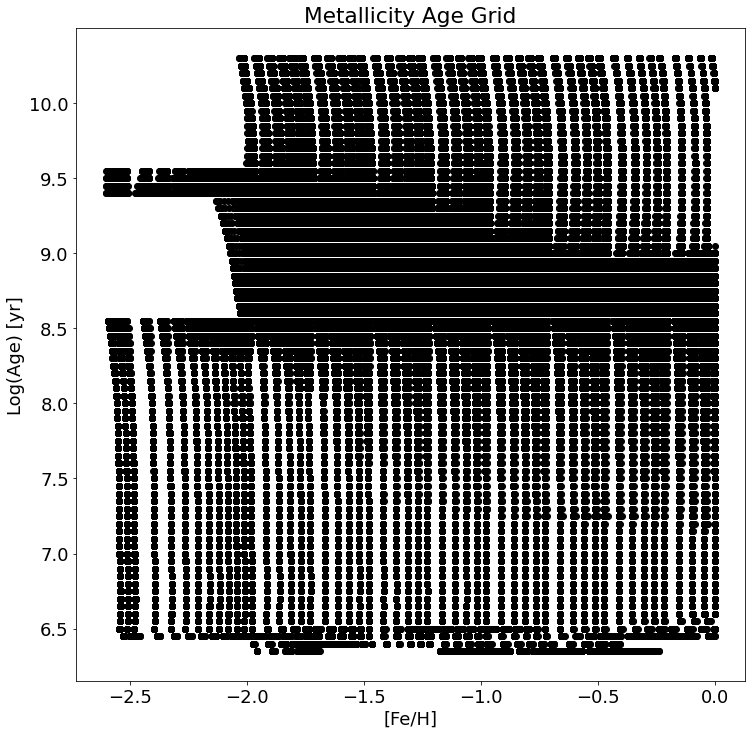

In [90]:
#Metallicity Age
plt.figure(figsize=[12,12])
plt.scatter(mist['[Fe/H]'],mist['log10_isochrone_age_yr'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
# plt.savefig('MISTrgbgrid.pdf',bbox_inches='tight')
plt.show()

In [91]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

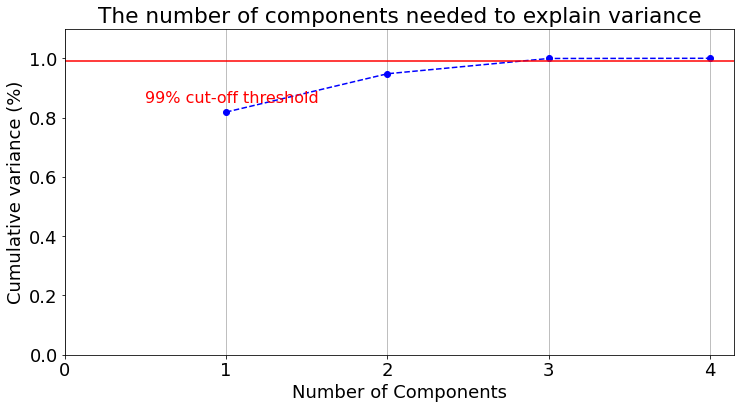

In [92]:
### Setup 
data = np.array([mist['log_Teff'],mist['2MASS_Ks'],mist['[Fe/H]'],mist['log_g']]).T

### Determine Number of factors
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [93]:
### Find all models

#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(mist['log10_isochrone_age_yr'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - mist['log10_isochrone_age_yr']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

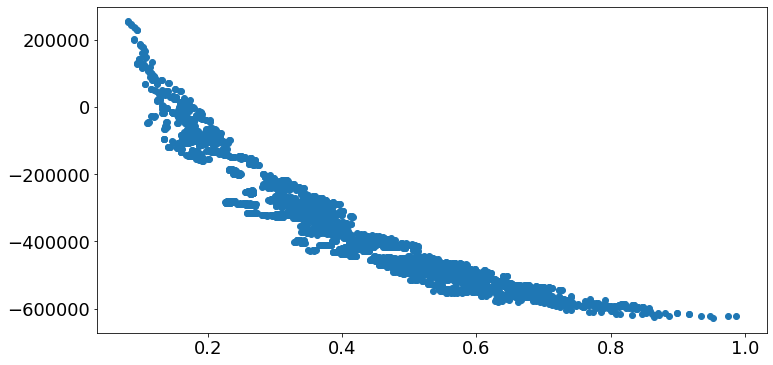

In [8]:
plt.scatter(mads,ll)

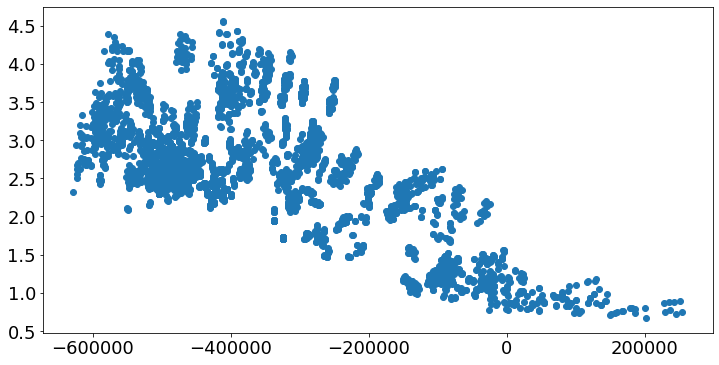

In [9]:
plt.scatter(ll,max_resid)

In [11]:
# models_str[np.asarray(max_resid).argmin()]

In [10]:
models_str[np.asarray(mads).argmin()]

array(['x1', 'x2', 'x3', 'x12', 'x13', 'x23', 'x1sq', 'x2sq', 'x3sq',
       'x1cu', 'x2cu'], dtype='<U4')

In [11]:
# models_str[np.asarray(mads).argmin()]

In [12]:
models_str[np.asarray(max_resid).argmin()]

array(['x1', 'x2', 'x3', 'x12', 'x13', 'x23', 'x2sq', 'x3sq', 'x1cu',
       'x2cu', 'x3cu'], dtype='<U4')

In [94]:
print(models_str[np.asarray(ll).argmax()])

['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu'
 'x3cu']


In [111]:
parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(mist['log10_isochrone_age_yr'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - mist['log10_isochrone_age_yr']
print(afunc.mad(parsimonious_residual))
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

0.08565276076082995
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 2.628e+06
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:46:49   Log-Likelihood:             2.4575e+05
No. Observations:              409551   AIC:                        -4.915e+05
Df Residuals:                  409539   BIC:                        -4.913e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8461      0.000

In [112]:
def find_ages(z1,z2,z3):
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu
    p = [7.84606177, -0.38112509,  0.95338481,  0.76975388, -0.13344995, -0.12527438,
  0.46533789,  0.01963405,  0.31359305,  0.26018088,  0.04868878,  0.05937542]
    age = (p[0]+
           p[1]*z1+p[2]*z2+p[3]*z3+
           p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+
           p[10]*(z2**3)+p[11]*(z3**3))#+p[12]*(z3**3))
    
    return age


<font size='48'>
    <b>
        CALCULATE AGES
    </b>
</font>

In [45]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [113]:
age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [114]:
# print(np.where(parages<=np.log10(0.5*10**9)))
# print(np.log10(0.5*10**9))
# plt.hist(parages,range=(8,12))

Text(0, 0.5, 'Bayesian')

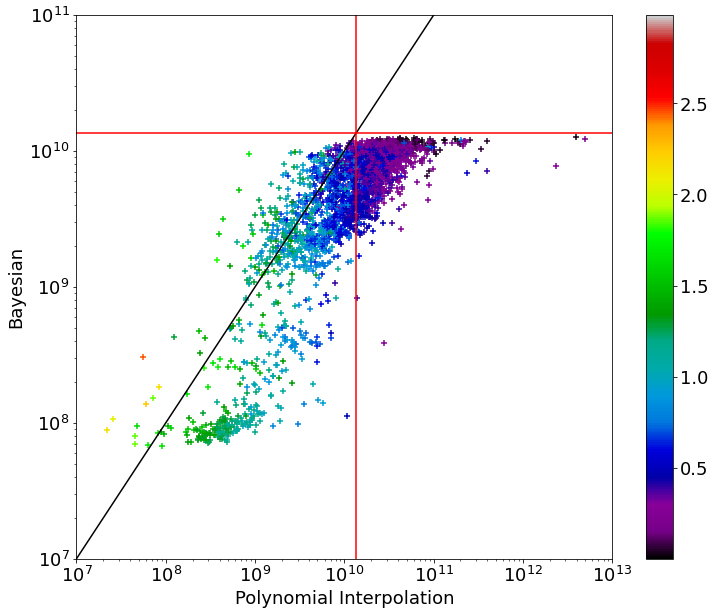

In [115]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')

plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.axvline(10**10.13,c='r')#9879086401237,c='r')
plt.axhline(10**10.13,c='r')#9879086401237,c='r')

plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')

Text(0, 0.5, 'Bayesian')

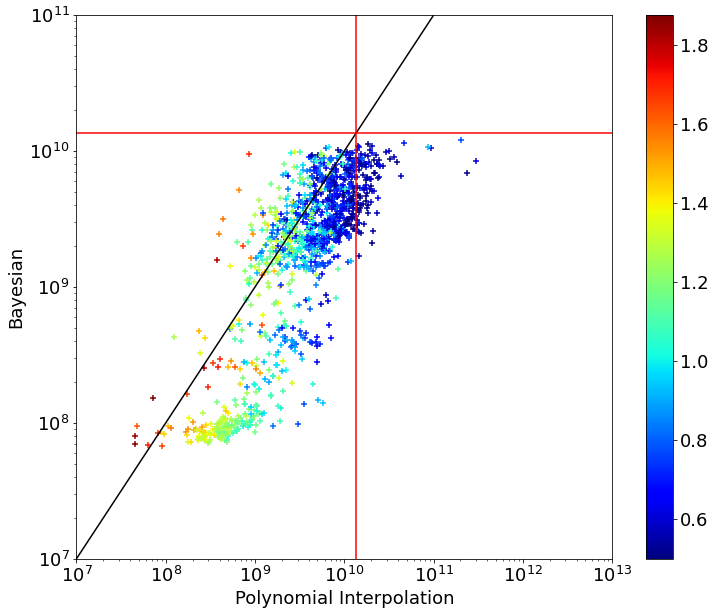

In [116]:
g_cut = np.where((r13[r13_ind]['LOGG']>=0.5)&(r13[r13_ind]['LOGG']<=2.0))

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[r13_ind][g_cut],10**pdfout['P_MEAN'][pdfout_ind][g_cut],
            c=r13['LOGG'][r13_ind][g_cut],marker='+',cmap='jet')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')

plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.axvline(10**10.13,c='r')#9879086401237,c='r')
plt.axhline(10**10.13,c='r')#9879086401237,c='r')

plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')

In [104]:
len(np.squeeze(g_cut))/len(r13)

0.44938176197836166

In [105]:
# plt.hist(10**pdfout['P_MEAN'][pdfout_ind])

In [106]:
10**10.13

13489628825.916561

In [107]:
np.log10(13.8*10**9)

10.139879086401237

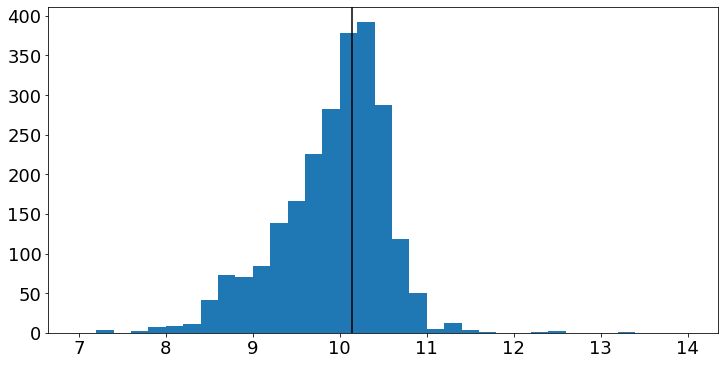

In [108]:
plt.hist(np.asarray(parages)[r13_ind],range=(7,14),bins=35)
plt.axvline(10.139879086401237,c='k')

In [60]:
print(np.median(np.asarray(parages)[r13_ind]))
print(afunc.mad(np.asarray(parages)[r13_ind]))

10.046721021971251
0.35130780147435203


In [34]:
# plt.hist(age_dist[100])

In [117]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_dist),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

# cat.write('TEST_pca_ols_ages.fits',format='fits')#,overwrite=True)
cat.write('mist_pca_ols_t_age.fits',format='fits',overwrite=True)

In [75]:
import itertools as it

### Model Variables ###

# linear terms
lgte_train = mist['log_Teff'] 
kmag_train = mist['2MASS_Ks'] 
feh_train = mist['[Fe/H]'] 
logg_train = mist['log_g'] 

# linear int
lgtekmag_train = np.multiply(lgte_train,kmag_train)
lgtefeh_train = np.multiply(lgte_train,feh_train)
lgtelogg_train = np.multiply(lgte_train,logg_train)

kmagfeh_train = np.multiply(kmag_train,feh_train)
kmaglogg_train = np.multiply(kmag_train,logg_train)

fehlogg_train = np.multiply(feh_train,logg_train)

# squares
lgtesq_train = lgte_train**2
kmagsq_train = kmag_train**2
fehsq_train = feh_train**2
loggsq_train = logg_train**2

# cubes
lgtecu_train = lgte_train**3
kmagcu_train = kmag_train**3
fehcu_train = feh_train**3
loggcu_train = logg_train**3


#find all possible models
models = []
models_str = []

all_var_str = ['lgte','kmag','feh','logg','lgtekmag','lgtefeh','lgtelogg','kmagfeh','kmaglogg','fehlogg',
               'lgtesq','kmagsq','fehsq','loggsq','lgtecu','kmagcu','fehcu','loggcu']
all_var = [lgte_train,kmag_train,feh_train,logg_train,lgtekmag_train,lgtefeh_train,lgtelogg_train,kmagfeh_train,
           kmaglogg_train,fehlogg_train,lgtesq_train,kmagsq_train,fehsq_train,loggsq_train,lgtecu_train,
           kmagcu_train,fehcu_train,loggcu_train]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(mist['log10_isochrone_age_yr'],pmodl).fit()
    summaries.append(model.summary())
    residual = model.predict(pmodl) - mist['log10_isochrone_age_yr']
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

KeyboardInterrupt: 

In [36]:
# ### Find all models

# #transform data to new basis
# # new_data = PCA(n_components=3).fit(data).transform(data)

# #create new variables

# # linear terms
# x1 = parsec['logTe'] #new_data[:,0]
# x2 = parsec['Ksmag'] #new_data[:,1]
# x3 = parsec['MH'] #new_data[:,2]
# x4 = parsec['logg']

# # linear int
# x12 = np.multiply(x1,x2)
# x13 = np.multiply(x1,x3)
# x14 = np.multiply(x1,x4)

# x23 = np.multiply(x2,x3)
# x24 = np.multiply(x2,x4)

# x34 = np.multiply(x3,x4)


# # squares
# x1sq = x1**2
# x2sq = x2**2
# x3sq = x3**2
# x4sq = x4**2

# # cubes
# # x1cu = x1**3
# # x2cu = x2**3
# # x3cu = x3**3


# #find all possible models
# models = []
# models_str = []

# all_var_str = ['x1','x2','x3','x4','x12','x13','x23','x24','x34','x1sq','x2sq','x3sq','x4sq']
# all_var = [x1,x2,x3,x4,x12,x13,x23,x24,x34,x1sq,x2sq,x3sq,x4sq]

# for i in range(1,len(all_var)+1):
#     for subset in it.combinations(all_var,i):
#         models.append(subset)
#     for subset_str in it.combinations(all_var_str,i):
#         models_str.append(np.array(subset_str))
        
# models = np.array(models)
# models_str = np.array(models_str)

# ### Fit All Models

# import statsmodels.api as sm 

# all_params = []
# summaries = []
# max_resid = []
# mads = []
# resids = []
# predict = []
# ll = []
# for i in tqdm_notebook(range(len(models)),desc='Done?'):
#     pmodl = np.array(models[i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     summaries.append(model.summary())
#     predictions = model.predict(pmodl)
#     predict.append(predictions)
#     residual = predictions - parsec['logAge']
#     resids.append(residual)
#     all_params.append(np.asarray(model.params))
#     max_resid.append(np.max(np.absolute(residual)))
#     mads.append(afunc.mad(residual))
#     ll.append(model.llf)

In [37]:
# print(summaries[np.asarray(ll).argmax()])
# print(all_params[np.asarray(ll).argmax()])
# print(models_str[np.asarray(ll).argmax()])


In [38]:
# print(summaries[np.asarray(mads).argmin()])
# print(all_params[np.asarray(mads).argmin()])
# print(models_str[np.asarray(mads).argmin()])

In [39]:
# def find_ages(z1,z2,z3,z4):
# #     p = [9.77943559e+02,-5.25226935e+02,1.24426878e+01,-1.71063906e+01,-3.33360237e+00,4.80431454e+00,
# #          -6.62127176e-02,3.89523313e-01,-8.75802774e-02,7.16174805e+01,-3.29702782e-02,1.69804627e-01,
# #          -5.39563301e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
# #             p[7]*np.multiply(z2,z4)+p[8]*np.multiply(z3,z4)+p[9]*(z1**2)+p[10]*(z2**2)+p[11]*(z3**2)+
# #             p[12]*(z4**2))

# #     p = [9.80851387e+02,-5.24981733e+02,1.26388036e+01,-1.48527724e+01,-3.38508869e+00,4.09636862e+00,
# #          -8.83269488e-02,3.70451942e-01,7.13126367e+01,-3.11197530e-02,1.35549807e-01,-5.05326057e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
# #             p[7]*np.multiply(z2,z4)+p[8]*(z1**2)+p[9]*(z2**2)+p[10]*(z3**2)+p[11]*(z4**2))

#     p = [1.62773106e+02,-7.74432139e+01,5.79432496e+00,-8.21554113e-01,-6.31502225e+00,-8.53547492e-01,
#          3.03422107e-01,-1.21805077e-02,-4.28300766e-01,-1.54961212e-03,1.08410088e+01,1.01740575e-01,
#          7.55430356e-02,4.96225871e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*z4+p[5]*np.multiply(z1,z2)+p[6]*np.multiply(z1,z3)+
#             p[7]*np.multiply(z2,z3)+p[8]*np.multiply(z2,z4)+p[9]*np.multiply(z3,z4)+p[10]*(z1**2)+p[11]*(z2**2)+
#             p[12]*(z3**3)+p[13]*(z4**2))
    
# #     p = [1.17993328e+02,-5.31336187e+01,5.45824048e+00,2.99452735e-01,-6.47520602e+00,-7.47386878e-01,
# #          -8.83982229e-03,-4.45546306e-01,7.56108649e+00,1.04148096e-01,7.17546427e-02,5.20605161e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*z4+p[5]*np.multiply(z1,z2)+p[6]*np.multiply(z1,z3)+
# #             p[7]*np.multiply(z2,z3)+p[8]*np.multiply(z2,z4)+p[8]*(z1**2)+p[9]*(z2**2)+p[10]*(z3**2)+p[11]*(z4**2))
#     return ages

In [40]:
# len(all_params[np.asarray(ll).argmax()])
# len(models_str[np.asarray(ll).argmax()])

In [41]:
# age_dist = []

# pca_transform = PCA(n_components=3).fit(data)

# for i in tqdm_notebook(range(len(r13)),desc='Done?'):
#     # temperature
#     teff = r13['TEFF'][i]
#     teff_err = r13['TEFF_ERR'][i]
    
#     # photometry 
#     ra = r13['RA'][i]
#     dec = r13['DEC'][i]
#     ks = r13['K'][i]
#     ks_err = r13['K_ERR'][i]
#     ak = r13['AK_TARG'][i]
    
#     # abundances
#     mh = r13['M_H'][i]
#     mh_err = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfe_err = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfe_err = r13['N_FE_ERR'][i]
#     feh = r13['FE_H'][i]
#     feh_err = r13['FE_H_ERR'][i]
    
#     # surface gravity
#     lgg = r13['LOGG'][i]
#     lgg_err = r13['LOGG_ERR'][i]
    
#     noise_ages = []
#     new = []
#     for j in range(100):
       
#         # calculate noisy temperature
#         teff_new = add_noise(teff,teff_err) 
#         lgteff_new = np.log10(teff_new)
    
#         # Calculate noisy K magnitude
#         _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
#         ks_new = add_noise(ks,ks_err)
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
#         # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
#         mh_new = add_noise(mh,mh_err)
        
#         # Calculate noisy surface gravity
#         lgg_new = add_noise(lgg,lgg_err)
            
#         # calculate noisy age
# #         new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
# #     zs = pca_transform.transform(np.asarray(np.squeeze(new)))

# #     for l in range(len(zs)):
#         noise_ages.append(find_ages(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
    
#     age_dist.append(noise_ages)

# parages = [] 
# devs = []
# for k in tqdm_notebook(range(len(age_dist))):
#     devs.append(afunc.mad(age_dist[k]))
#     parages.append(np.median(age_dist[k]))

In [42]:
# plt.hist(parages)

In [43]:
# plt.figure(figsize=[12,10])
# plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
#                 marker='+',cmap='nipy_spectral')
# plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
# plt.ylim(10**7,10**11)
# plt.xlim(10**7,10**13)